In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import interpolate, integrate

from gwbench import basic_relations as br
from pycbc import conversions as conv


import gwbench_network_funcs as gwnet

import astropy.units as u
from astropy.cosmology import Planck18, z_at_value


In [2]:
import matplotlib as mpl

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 18
})


%config InlineBackend.figure_format='retina' # very useful command for high-res images

# What factor to scale SNRs by?

In [30]:
input_file = 'smooth_powerlaw_pop.npz'
with np.load(input_file, mmap_mode='r') as binaries:
    Mcs = np.array(binaries['Mcs'])
    etas = np.array(binaries['etas'])
    chi1z = np.array(binaries['chi1z'])
    chi2z = np.array(binaries['chi2z'])
    DLs = np.array(binaries['DLs'])
    iotas = np.array(binaries['iotas'])
    ras = np.array(binaries['ras'])
    decs = np.array(binaries['decs'])
    psis = np.array(binaries['psis'])



In [38]:
N = 100 # takes ~17 sec for 100 binaries
snrs_3G = np.zeros(N)
snrs_LIGO = np.zeros(N)

for i in range(N):
    inj_params = {
        'Mc':    Mcs[i],
        'eta':   etas[i],
        'chi1x': 0.,
        'chi2x': 0.,
        'chi1y': 0.,
        'chi2y': 0.,
        'chi1z': chi1z[i],
        'chi2z': chi2z[i],
        'DL':    DLs[i],
        'tc':    0,
        'phic':  0,
        'iota':  iotas[i],
        'ra':    ras[i],
        'dec':   decs[i],
        'psi':   psis[i],
        'gmst0': 0,
        'hybr': 0.0
    } 

    net_key = '3G'

    approx1 = 'IMRPhenomXAS'

    d_f = 2**-4
    f_low = 5.0
    mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
    f_high = np.round(4*br.f_isco_Msolar(mtotal))


    snrs_3G[i] = gwnet.get_network_snr(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key='3G').snr
    snrs_LIGO[i] = gwnet.get_network_snr(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key='aLIGO').snr
    


2023-10-30 11:20:27,892 - Network - INFO : PSDs loaded.
2023-10-30 11:20:27,894 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-30 11:20:27,910 - Network - INFO : Detector responses calculated.
2023-10-30 11:20:27,914 - Network - INFO : SNRs calculated.
2023-10-30 11:20:27,928 - Network - INFO : PSDs loaded.
2023-10-30 11:20:27,930 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-30 11:20:27,940 - Network - INFO : Detector responses calculated.
2023-10-30 11:20:27,944 - Network - INFO : SNRs calculated.
2023-10-30 11:20:27,990 - Network - INFO : PSDs loaded.
2023-10-30 11:20:27,992 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-30 11:20:28,005 - Network - INFO : Detector responses calculated.
2023-10-30 11:20:28,007 - Network - INFO : SNRs calculated.
2023-10-30 11:20:28,019 - Network - INFO : PSDs loaded.
2023-10-30 11:20:28,021 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-30 11:20:28,030 - Network - INFO : Detector responses calc

[0.70077594 0.25560533 0.8254957  1.12649298 1.50116892 1.0613048
 0.2799822  1.71450879 3.51968164 0.27593897 0.59232614 0.90508707
 1.44236812 0.87078453 0.94600946 0.61356682 3.63865762 0.91323843
 1.18647596 0.55893843 0.60404421 1.73940946 0.55557891 1.02236244
 0.57467424 1.99979115 1.36052471 0.5307226  1.34097562 1.57999515
 3.17867065 1.53279728 0.83827163 0.53523248 0.88099211 1.14353038
 2.49330581 2.13258435 0.98532805 0.87753831 0.44752942 0.92440252
 0.79029131 0.87821796 0.7215087  2.70612615 1.15132842 5.34915125
 1.68476542 0.42849332 1.37181726 0.39156978 0.38629866 0.75809512
 0.5039451  0.35693704 1.72384652 0.44749933 1.15562319 0.55672181
 0.84608629 0.67462307 0.61333105 0.48309933 0.7772633  0.51510264
 3.59268326 1.53416852 3.33522593 0.79005844 0.8414483  0.40072451
 0.91800929 0.80488134 1.14396321 0.53872988 1.50482397 3.70292959
 1.54188915 0.83853626 1.01603098 1.51648411 1.3771792  1.77962554
 1.16359167 0.6137203  0.63129548 1.35507341 2.98004105 1.19133

In [41]:
snr_ratios = snrs_3G/snrs_LIGO
np.mean(snr_ratios)

23.505270658677443

The SNRs in 3G seem to be ~20 times the SNRs in LIGO.

# Predicted 3G mass spectrum

In [3]:
# https://gwosc.org/eventapi/html/GWTC-3-confident/
# df = pd.read_csv('RfubJcBi.csv')

# https://gwosc.org/eventapi/html/GWTC/
df = pd.read_csv('Pn1s25sH.csv')

df = df.dropna(subset=['mass_1_source'])
df = df[df['mass_1_source']>2.5]

In [4]:
df.columns

Index(['id', 'commonName', 'version', 'catalog.shortName', 'GPS', 'reference',
       'jsonurl', 'mass_1_source', 'mass_1_source_lower',
       'mass_1_source_upper', 'mass_2_source', 'mass_2_source_lower',
       'mass_2_source_upper', 'network_matched_filter_snr',
       'network_matched_filter_snr_lower', 'network_matched_filter_snr_upper',
       'luminosity_distance', 'luminosity_distance_lower',
       'luminosity_distance_upper', 'chi_eff', 'chi_eff_lower',
       'chi_eff_upper', 'total_mass_source', 'total_mass_source_lower',
       'total_mass_source_upper', 'chirp_mass_source',
       'chirp_mass_source_lower', 'chirp_mass_source_upper', 'chirp_mass',
       'chirp_mass_lower', 'chirp_mass_upper', 'redshift', 'redshift_lower',
       'redshift_upper', 'far', 'far_lower', 'far_upper', 'p_astro',
       'p_astro_lower', 'p_astro_upper', 'final_mass_source',
       'final_mass_source_lower', 'final_mass_source_upper'],
      dtype='object')

In [5]:
df

,id,commonName,version,catalog.shortName,GPS,reference,jsonurl,mass_1_source,mass_1_source_lower,mass_1_source_upper,...,redshift_upper,far,far_lower,far_upper,p_astro,p_astro_lower,p_astro_upper,final_mass_source,final_mass_source_lower,final_mass_source_upper
0,GW150914-v3,GW150914,3,GWTC-1-confident,1.126259e+09,https://doi.org/10.7935/82H3-HH23,https://gwosc.org/eventapi/json/GWTC-1-confide...,35.6,-3.1,4.7,...,0.03,1.000000e-07,NaN,NaN,1.00000,NaN,NaN,63.1,-3.0,3.4
1,GW151012-v3,GW151012,3,GWTC-1-confident,1.128679e+09,https://doi.org/10.7935/82H3-HH23,https://gwosc.org/eventapi/json/GWTC-1-confide...,23.2,-5.5,14.9,...,0.09,7.920000e-03,NaN,NaN,1.00000,NaN,NaN,35.6,-3.8,10.8
2,GW151226-v2,GW151226,2,GWTC-1-confident,1.135136e+09,https://doi.org/10.7935/82H3-HH23,https://gwosc.org/eventapi/json/GWTC-1-confide...,13.7,-3.2,8.8,...,0.04,1.000000e-07,NaN,NaN,1.00000,NaN,NaN,20.5,-1.5,6.4
3,GW170104-v2,GW170104,2,GWTC-1-confident,1.167560e+09,https://doi.org/10.7935/82H3-HH23,https://gwosc.org/eventapi/json/GWTC-1-confide...,30.8,-5.6,7.3,...,0.08,1.000000e-07,NaN,NaN,1.00000,NaN,NaN,48.9,-4.0,5.1
4,GW170608-v3,GW170608,3,GWTC-1-confident,1.180922e+09,https://doi.org/10.7935/82H3-HH23,https://gwosc.org/eventapi/json/GWTC-1-confide...,11.0,-1.7,5.5,...,0.02,1.000000e-07,NaN,NaN,1.00000,NaN,NaN,17.8,-0.7,3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,GW200306_093714-v1,GW200306_093714,1,GWTC-3-confident,1.267523e+09,/GWTC-3/,https://gwosc.org/eventapi/json/GWTC-3-confide...,28.3,-7.7,17.1,...,0.24,2.400000e+01,NaN,NaN,0.81156,NaN,NaN,41.7,-6.9,12.3
89,GW200308_173609-v1,GW200308_173609,1,GWTC-3-confident,1.267724e+09,/GWTC-3/,https://gwosc.org/eventapi/json/GWTC-3-confide...,36.4,-9.6,11.2,...,0.32,2.400000e+00,NaN,NaN,0.85660,NaN,NaN,47.4,-7.7,11.1
90,GW200311_115853-v1,GW200311_115853,1,GWTC-3-confident,1.267963e+09,/GWTC-3/,https://gwosc.org/eventapi/json/GWTC-3-confide...,34.2,-3.8,6.4,...,0.05,1.000000e-05,NaN,NaN,0.99000,NaN,NaN,59.0,-3.9,4.8
91,GW200316_215756-v1,GW200316_215756,1,GWTC-3-confident,1.268431e+09,/GWTC-3/,https://gwosc.org/eventapi/json/GWTC-3-confide...,13.1,-2.9,10.2,...,0.08,1.000000e-05,NaN,NaN,0.99000,NaN,NaN,20.2,-1.9,7.4


In [6]:
print(np.sort(df['luminosity_distance'])[::-1])

print(z_at_value(Planck18.luminosity_distance, np.sort(df['luminosity_distance'])[::-1]*u.Mpc))


[8280. 6130. 6000. 5400. 4940. 4580. 4300. 4100. 4000. 3890. 3800. 3800.
 3730. 3630. 3600. 3400. 3400. 3400. 3400. 3330. 3320. 3310. 3280. 3190.
 3130. 3070. 3000. 2910. 2840. 2840. 2600. 2590. 2520. 2230. 2210. 2100.
 2090. 2070. 1940. 1930. 1800. 1790. 1750. 1710. 1620. 1540. 1540. 1520.
 1520. 1480. 1460. 1370. 1290. 1250. 1170. 1150. 1150. 1120. 1080. 1080.
 1060. 1030. 1030.  990.  990.  940.  930.  930.  900.  880.  870.  850.
  790.  770.  770.  720.  720.  650.  600.  550.  550.  450.  440.  410.
  340.  320.  290.  230.]
[1.17443449 0.9201545  0.90425695 0.82993142 0.77177668 0.72546015
 0.68889467 0.66246108 0.64913963 0.63440183 0.62227583 0.62227583
 0.61280101 0.59919758 0.59510059 0.56759167 0.56759167 0.56759167
 0.56759167 0.5578802  0.5564892  0.55509727 0.55091593 0.53832094
 0.52988083 0.52140502 0.51147033 0.4986218  0.48856805 0.48856805
 0.45367356 0.4522047  0.44188768 0.39845547 0.39541668 0.37859621
 0.37705788 0.3739765  0.35379039 0.35222601 0.33173105 0.330

In [11]:
data = np.abs(df['chi_eff_upper'] / df['chi_eff'])
print(np.sum(data<0.5))

3


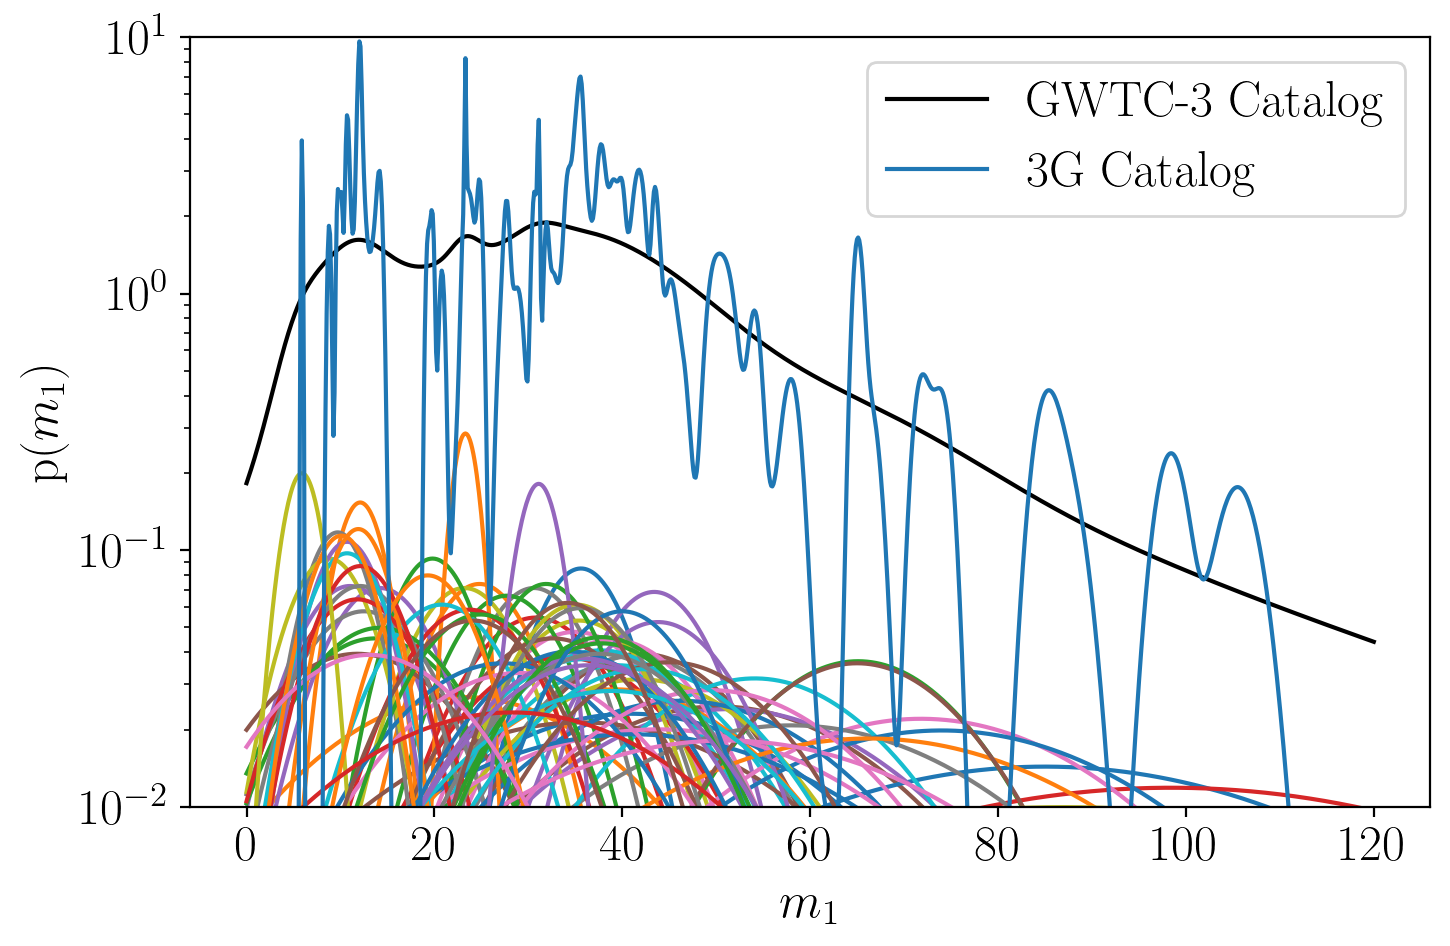

In [68]:
m1_range = np.linspace(0, 120, 1000)
pdf_m1_total_LIGO = np.zeros(len(m1_range))
pdf_m1_total_3G = np.zeros(len(m1_range))



fig, ax = plt.subplots(figsize=(8,5))

for i in range(len(df)):
    m1 = df.iloc[i]["mass_1_source"]
    sigma_m1 = df.iloc[i]["mass_1_source_upper"]
    p_m1 = norm(loc=m1, scale=sigma_m1).pdf

    pdf_m1_total_LIGO += p_m1(m1_range)
    pdf_m1_total_3G += norm(loc=m1, scale=sigma_m1/20).pdf(m1_range)

    plt.plot(m1_range, p_m1(m1_range))

plt.plot(m1_range, pdf_m1_total_LIGO, color='k', label='GWTC-3 Catalog')
plt.plot(m1_range, pdf_m1_total_3G, color='C0', label='3G Catalog')

plt.legend()
plt.semilogy()
plt.ylim(1e-2, 1e1)

plt.xlabel("$m_1$")
plt.ylabel("p($m_1$)")

plt.show()


In [69]:
num_injs = 100
cdf_m1_LIGO = integrate.cumulative_trapezoid(pdf_m1_total_LIGO, m1_range, initial=0)
inv_cdf_m1_LIGO = interpolate.interp1d(cdf_m1_LIGO / cdf_m1_LIGO[-1], m1_range)
m1_LIGO_samples = inv_cdf_m1_LIGO(np.random.rand(num_injs))

num_injs = 100000
cdf_m1_3G = integrate.cumulative_trapezoid(pdf_m1_total_3G, m1_range, initial=0)
inv_cdf_m1_3G = interpolate.interp1d(cdf_m1_3G / cdf_m1_3G[-1], m1_range)
m1_3G_samples = inv_cdf_m1_3G(np.random.rand(num_injs))


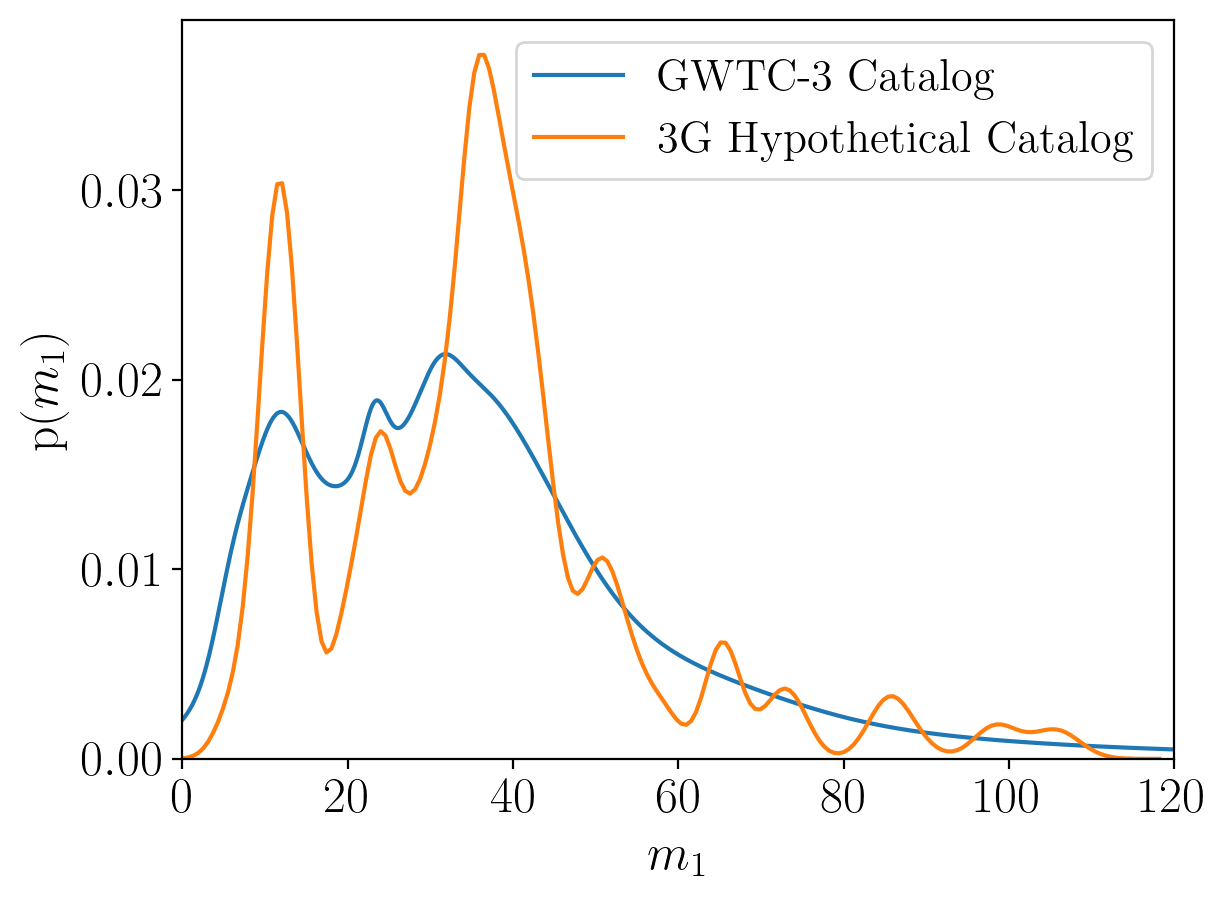

In [80]:
plt.plot(m1_range, 8*pdf_m1_total_LIGO/np.sum(pdf_m1_total_LIGO), label='GWTC-3 Catalog')
# sns.kdeplot(m1_LIGO_samples, label='GWTC-3 Catalog')
sns.kdeplot(m1_3G_samples, label='3G Hypothetical Catalog')

# plt.plot(m1_range, 8*pdf_m1_total_LIGO/np.sum(pdf_m1_total_LIGO), color='k', label='GWTC-3 Catalog')
# plt.semilogy()
# plt.ylim(1e-3, 1e-1)
plt.xlim(0, 120)

plt.xlabel("$m_1$")
plt.ylabel("p($m_1$)")

plt.legend(fontsize=16)

plt.show()


# Predicted 3G $\chi_{eff}$ spectrum

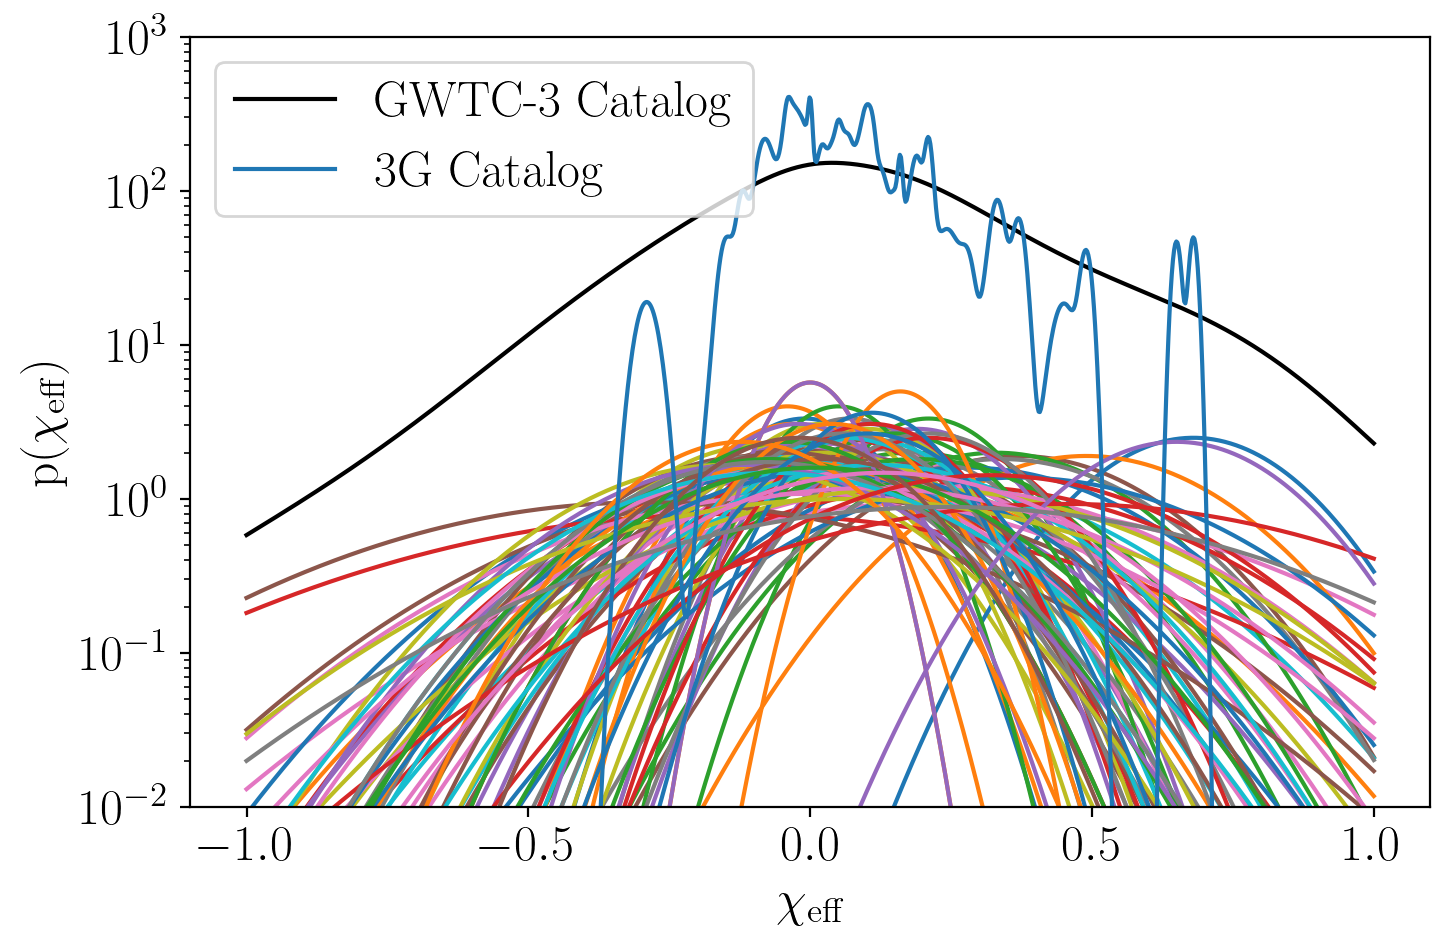

In [7]:
chi_range = np.linspace(-1.0, 1.0, 1000)
pdf_chi_total_LIGO = np.zeros(len(chi_range))
pdf_chi_total_3G = np.zeros(len(chi_range))



fig, ax = plt.subplots(figsize=(8,5))
for i in range(len(df)):
    chi = df.iloc[i]["chi_eff"]
    sigma_chi = df.iloc[i]["chi_eff_upper"]
    p_chi = norm(loc=chi, scale=sigma_chi).pdf
    pdf_chi_total_LIGO += p_chi(chi_range)

    pdf_chi_total_3G += norm(loc=chi, scale=sigma_chi/20).pdf(chi_range)

    plt.plot(chi_range, p_chi(chi_range))

plt.plot(chi_range, pdf_chi_total_LIGO, color='k', label='GWTC-3 Catalog')
plt.plot(chi_range, pdf_chi_total_3G, color='C0', label='3G Catalog')

plt.legend()
plt.semilogy()
plt.ylim(1e-2, 1e3)

plt.xlabel("$\chi_{\\rm eff}$")
plt.ylabel("p($\chi_{\\rm eff}$)")

plt.show()

In [8]:
num_injs = 100
cdf_chi_LIGO = integrate.cumulative_trapezoid(pdf_chi_total_LIGO, chi_range, initial=0)
inv_cdf_chi_LIGO = interpolate.interp1d(cdf_chi_LIGO / cdf_chi_LIGO[-1], chi_range)
chi_LIGO_samples = inv_cdf_chi_LIGO(np.random.rand(num_injs))

num_injs = 100000
cdf_chi_3G = integrate.cumulative_trapezoid(pdf_chi_total_3G, chi_range, initial=0)
inv_cdf_chi_3G = interpolate.interp1d(cdf_chi_3G / cdf_chi_3G[-1], chi_range)
chi_3G_samples = inv_cdf_chi_3G(np.random.rand(num_injs))


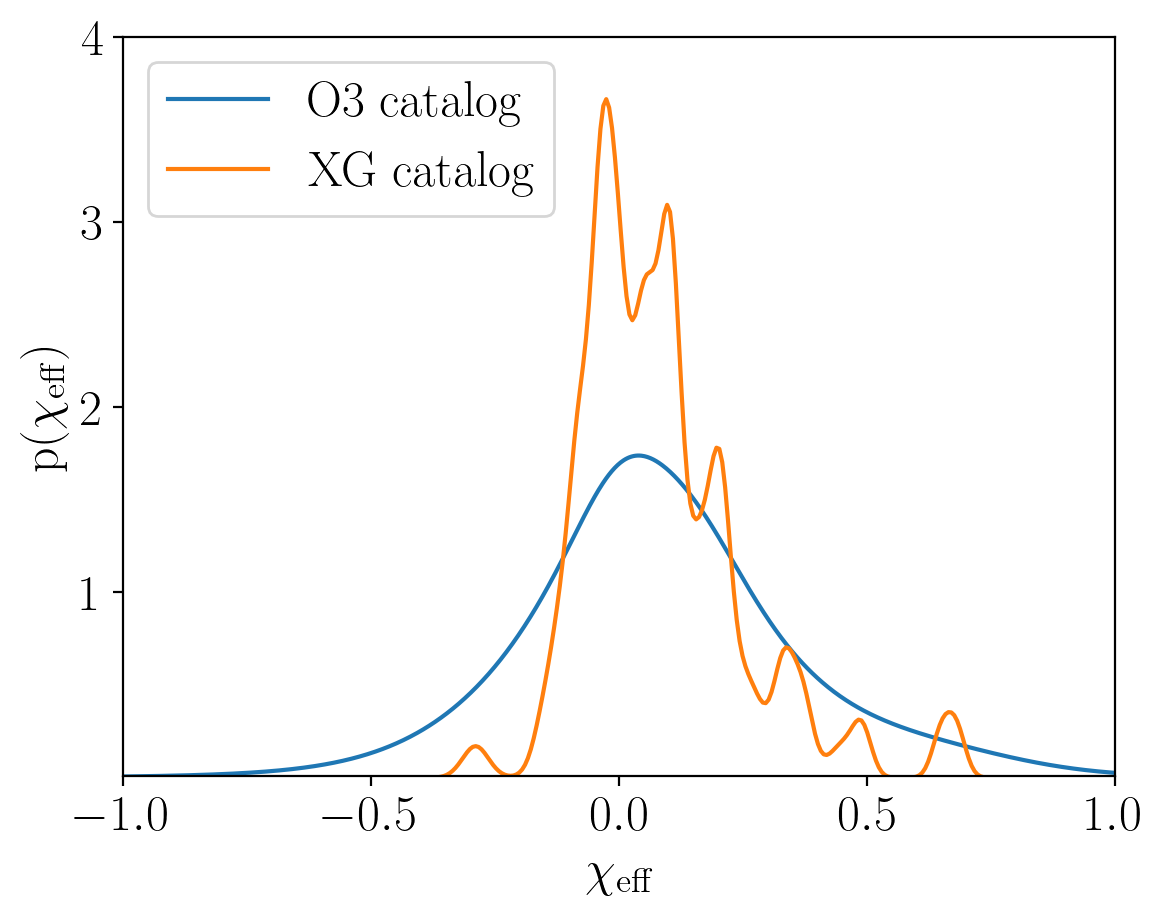

In [21]:
# sns.kdeplot(chi_LIGO_samples, label='GWTC-3 Catalog')
plt.plot(chi_range, 500*pdf_chi_total_LIGO/np.sum(pdf_chi_total_LIGO), label='O3 catalog')

sns.kdeplot(chi_3G_samples, label='XG catalog')

# plt.semilogy()

plt.ylim(1e-2, 4)
plt.xlim(-1,1)

plt.xlabel("$\chi_{\\rm eff}$")
plt.ylabel("p($\chi_{\\rm eff}$)")

plt.legend(loc='upper left')

plt.show()


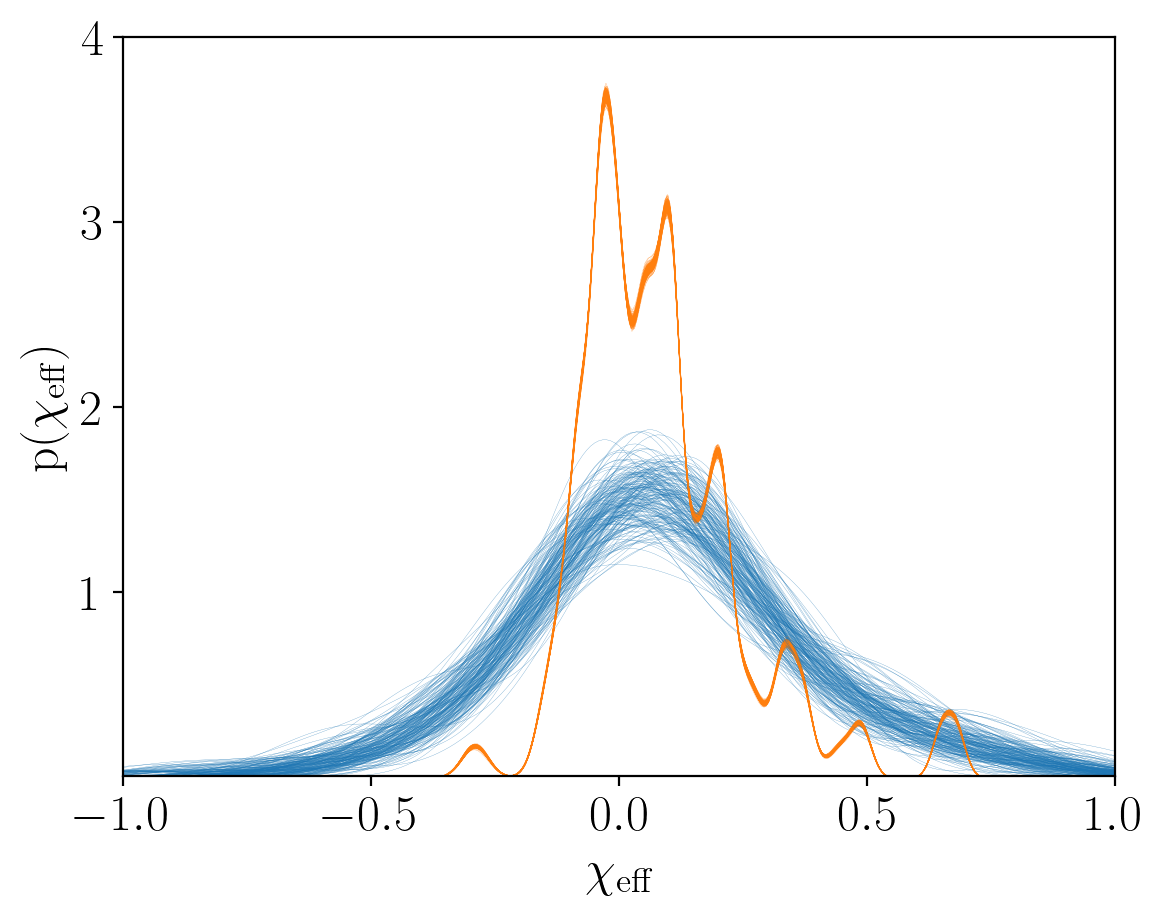

In [16]:
N = 200
for i in range(N):
    num_injs = 100
    cdf_chi_LIGO = integrate.cumulative_trapezoid(pdf_chi_total_LIGO, chi_range, initial=0)
    inv_cdf_chi_LIGO = interpolate.interp1d(cdf_chi_LIGO / cdf_chi_LIGO[-1], chi_range)
    chi_LIGO_samples = inv_cdf_chi_LIGO(np.random.rand(num_injs))

    num_injs = 100000
    cdf_chi_3G = integrate.cumulative_trapezoid(pdf_chi_total_3G, chi_range, initial=0)
    inv_cdf_chi_3G = interpolate.interp1d(cdf_chi_3G / cdf_chi_3G[-1], chi_range)
    chi_3G_samples = inv_cdf_chi_3G(np.random.rand(num_injs))

    sns.kdeplot(chi_LIGO_samples, lw=0.1, alpha=0.8, c='C0')
    sns.kdeplot(chi_3G_samples, lw=0.1, alpha=0.8, c='C1')

    plt.ylim(1e-2, 4)
    plt.xlim(-1,1)

    plt.xlabel("$\chi_{\\rm eff}$")
    plt.ylabel("p($\chi_{\\rm eff}$)")

plt.show()
